## Part III: feature engineering and rating model development

#### In this section, we will pre-processing the review data and perform feature engineering for the rating model development. Because there are totally 916 conditions covered in this set, we will select the top 3 of them as our study dataset, birth control, pain and depression. 

### 3.1 data pre-processing

In [64]:
import re
import nltk
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [65]:
df=pd.read_csv('data/df_EDA.csv', index_col=0)
df.head(3)

,drugName,condition,review,rating,date,usefulCount,year,month,weekday,clean_re,sent_len,word_len
163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22,2012,2,1,ve antidepressants years citalopram fluoxetine...,4,81
206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,2009-05-17,17,2009,5,6,son crohn disease asacol complaints show side ...,4,55
159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,2017-09-29,3,2017,9,4,quick reduction symptoms,1,6


In [66]:
df1=df.drop(['clean_re', 'sent_len'], axis=1)
df1=df1[df1.condition.isin(['Birth Control', 'Depression', 'Pain'])]

In [67]:
df.shape

(213869, 12)

In [68]:
df1.shape
#We will use df1 to develop the sentiment analysis model

(58845, 10)

In [69]:
#we will use the same stopwords for text data normalization as in EDA analysis
import requests
url = 'http://members.unine.ch/jacques.savoy/clef/englishST.txt'
r = requests.get(url)
with open('./data/englishST.txt', 'wb') as f:
    f.write(r.content)
stop_words = []
with open('data/englishST.txt', 'r') as f:
    [stop_words.append(word) for line in f for word in line.split()]
stopwords=set(stop_words)
len(stopwords)

570

In [70]:
#We will evaluate which stemmer is the best using several reviews
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
porter = PorterStemmer()
lancaster = LancasterStemmer()
from nltk.stem.wordnet import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

PorterStemmer being the oldest one originally developed in 1979. 
LancasterStemmer was developed in 1990 and uses a more aggressive approach than Porter Stemming Algorithm.The LancasterStemmer (Paice-Husk stemmer) is an iterative algorithm with rules saved externally. LancasterStemmer is simple, but heavy stemming due to iterations and over-stemming may occur. Over-stemming causes the stems to be not linguistic, or they may have no meaning.

In [71]:
#For sentiment analysis, we will use stemmer to progressively reduce the number of words
def clean_review_sentiment(review):
    review_text = BeautifulSoup(review, 'html.parser').get_text() #remove html tags
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text) #substitute all non-letter symbols with space
    words = letters_only.lower().split() #convert all element in the string into lower case
    useful_w=[w for w in words if not w in stopwords] #remove the most common stop words
    stem_w=[stemmer.stem(w) for w in useful_w] #we decided to use stemmer instead of lemmatizer because it is fast
    return( ' '.join(stem_w)) #join the stemming_words use space

In [72]:
df1['cl_review']=[clean_review_sentiment(i) for i in df1.review]

In [73]:
df1.head()

,drugName,condition,review,rating,date,usefulCount,year,month,weekday,word_len,cl_review
163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22,2012,2,1,81,ve antidepress year citalopram fluoxetin amitr...
97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,2015-10-22,4,2015,10,3,157,birth control cycl read review type similar bi...
215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6.0,2016-06-06,1,2016,6,0,114,ve copper coil month excit thought take hormon...
71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2.0,2011-04-16,3,2011,4,5,101,pill year work pregnant experi didn make huge ...
79865,Blisovi Fe 1 / 20,Birth Control,"""I absolutely love this product and recommend ...",10.0,2017-11-03,4,2017,11,4,95,absolut love product recommend bodi medicin fa...


<AxesSubplot:>

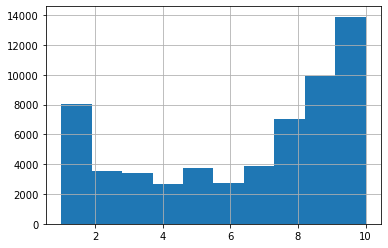

In [74]:
df1.rating.hist()

Most reviews have high ratings in this dataset. 

## 3.2 feature engineering and rating model development

### 3.2.1 use NLTK pre-trained sentiment analyzer, VADER, to get the sentiment indicator as predictor

NLTK has a built-in sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner).We can use it to extract the sentiment information in the review

In [75]:
#Using NLTK’s Pre-Trained Sentiment Analyzer, VADER (Valence Aware Dictionary and sEntiment Reasoner)
import nltk
nltk.download(["vader_lexicon"])
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gln_d\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [76]:
#Let's test dis_analyzer using nltk.sentiment.vader
df1.review.iloc[0]

'"I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me."'

In [77]:
sid_analyzer.polarity_scores(df1.review.iloc[0])

{'neg': 0.212, 'neu': 0.61, 'pos': 0.178, 'compound': -0.4596}

In [78]:
#use compound score as sentiment indicator
def sentiment_vader(review):
    c=sid_analyzer.polarity_scores(review).get('compound')
    return c   

In [79]:
sentiment_vader(df1.review.iloc[1])

0.9559

In [80]:
df1['vader_compound']=[sentiment_vader(i) for i in df1.review]

In [81]:
df1.head()

,drugName,condition,review,rating,date,usefulCount,year,month,weekday,word_len,cl_review,vader_compound
163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22,2012,2,1,81,ve antidepress year citalopram fluoxetin amitr...,-0.4596
97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,2015-10-22,4,2015,10,3,157,birth control cycl read review type similar bi...,0.9559
215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6.0,2016-06-06,1,2016,6,0,114,ve copper coil month excit thought take hormon...,-0.5998
71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2.0,2011-04-16,3,2011,4,5,101,pill year work pregnant experi didn make huge ...,-0.8901
79865,Blisovi Fe 1 / 20,Birth Control,"""I absolutely love this product and recommend ...",10.0,2017-11-03,4,2017,11,4,95,absolut love product recommend bodi medicin fa...,0.4468


### 3.2.2 use textblob pre-trained sentiment analyzer, TextBlob, to extract sentiment information as candidate features

Polarity is float which lies in the range of [-1,1]. where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1]. The detail can be found https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/

In [82]:
from textblob import TextBlob
blob = TextBlob("This restaurant was great, but I'm not sure if I'll go there again.")
blob.sentiment

Sentiment(polarity=0.275, subjectivity=0.8194444444444444)

In [83]:
blob.sentiment.polarity

0.275

In [84]:
df1['textblob_polarity']=[TextBlob(i).sentiment.polarity for i in df1.review]

In [85]:
df1['textblob.subjectivity']=[TextBlob(i).sentiment.subjectivity for i in df1.review]

In [86]:
#convert categorical variables into dummy variables
df1.drugName.nunique()

507

In [87]:
y=df1.rating
X=df1.drop(columns=['review', 'cl_review', 'date', 'rating', 'drugName'])

In [88]:
X.head()

,condition,usefulCount,year,month,weekday,word_len,vader_compound,textblob_polarity,textblob.subjectivity
163740,Depression,22,2012,2,1,81,-0.4596,0.000000,0.440000
97768,Birth Control,4,2015,10,3,157,0.9559,0.260926,0.550463
215892,Birth Control,1,2016,6,0,114,-0.5998,-0.110663,0.618027
71428,Birth Control,3,2011,4,5,101,-0.8901,-0.005889,0.546889
79865,Birth Control,4,2017,11,4,95,0.4468,0.071667,0.578333


### 3.2.3 data preparation for modeling 

In [89]:
y.dtypes

dtype('float64')

In [90]:
X.dtypes

condition                 object
usefulCount                int64
year                       int64
month                      int64
weekday                    int64
word_len                   int64
vader_compound           float64
textblob_polarity        float64
textblob.subjectivity    float64
dtype: object

In [91]:
con_dummy=pd.get_dummies(X.condition, drop_first=True)
con_dummy.rename(columns={'Depression':'con_1', 'Pain':'con_2'}, inplace=True)
con_dummy.head()

,con_1,con_2
163740,1,0
97768,0,0
215892,0,0
71428,0,0
79865,0,0


In [92]:
X=pd.concat([X, con_dummy], axis=1)
X.head()

,condition,usefulCount,year,month,weekday,word_len,vader_compound,textblob_polarity,textblob.subjectivity,con_1,con_2
163740,Depression,22,2012,2,1,81,-0.4596,0.000000,0.440000,1,0
97768,Birth Control,4,2015,10,3,157,0.9559,0.260926,0.550463,0,0
215892,Birth Control,1,2016,6,0,114,-0.5998,-0.110663,0.618027,0,0
71428,Birth Control,3,2011,4,5,101,-0.8901,-0.005889,0.546889,0,0
79865,Birth Control,4,2017,11,4,95,0.4468,0.071667,0.578333,0,0


In [93]:
X=X.drop(columns=['condition'])
#depression if con_1=1, pain if con_2=1, birth control if con_1 and con_2 both =0
X.head()

,usefulCount,year,month,weekday,word_len,vader_compound,textblob_polarity,textblob.subjectivity,con_1,con_2
163740,22,2012,2,1,81,-0.4596,0.000000,0.440000,1,0
97768,4,2015,10,3,157,0.9559,0.260926,0.550463,0,0
215892,1,2016,6,0,114,-0.5998,-0.110663,0.618027,0,0
71428,3,2011,4,5,101,-0.8901,-0.005889,0.546889,0,0
79865,4,2017,11,4,95,0.4468,0.071667,0.578333,0,0


In [94]:
X.dtypes

usefulCount                int64
year                       int64
month                      int64
weekday                    int64
word_len                   int64
vader_compound           float64
textblob_polarity        float64
textblob.subjectivity    float64
con_1                      uint8
con_2                      uint8
dtype: object

In [95]:
X.isna().sum()

usefulCount              0
year                     0
month                    0
weekday                  0
word_len                 0
vader_compound           0
textblob_polarity        0
textblob.subjectivity    0
con_1                    0
con_2                    0
dtype: int64

In [96]:
#Although many people just transform timestamp data into dummy variables before using sklearn modeling, what if I just leave them alone here?
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
#use stratified sampling to make sure the imbalance of DEFAULT will not have an effect on modeling
st_scaler=StandardScaler()
X_train_s=st_scaler.fit_transform(X_train)
X_test_s=st_scaler.transform(X_test)

### 3.2.4 model development

<AxesSubplot:>

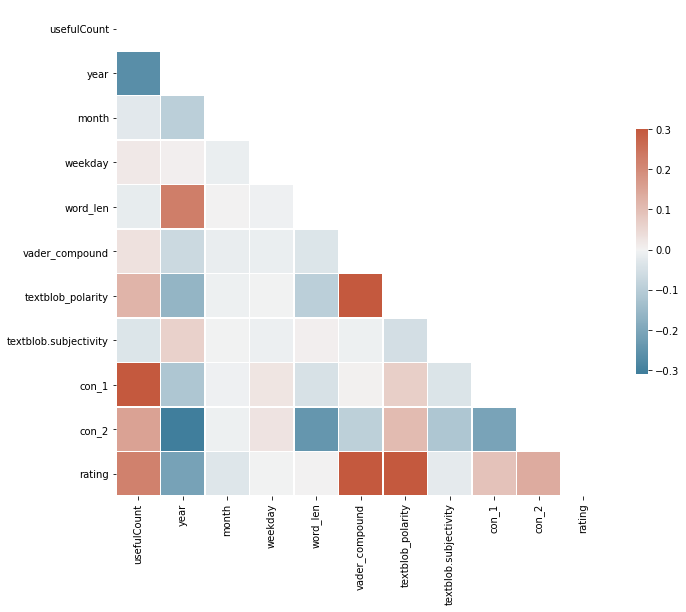

In [97]:
#let's check the correlation between predictors
import seaborn as sns
corr=pd.concat([X, y], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
#There is no obvious correlation between features in this study

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#### 3.2.4.1 Linear regression model

In [99]:
def LinearRegression_R(train_x, train_y, test_x, test_y):
    linear_reg = LinearRegression()
    linear_reg.fit(train_x, train_y)
    train_pred = linear_reg.predict(train_x)
    test_pred = linear_reg.predict(test_x)
    
    test_mse = mean_squared_error(test_y, test_pred)
    test_mae = mean_absolute_error(test_y, test_pred)
    test_r2 = r2_score(test_y, test_pred)
    
    train_mse = mean_squared_error(train_y, train_pred)
    train_mae = mean_absolute_error(train_y, train_pred)
    train_r2 = r2_score(train_y, train_pred)
    
    print("traning set results: MSE: %f, MAE: %f, R^2: %f" % (train_mse, train_mae, train_r2))
    print("test set results: MSE: %f, MAE: %f, R^2: %f" % (test_mse, test_mae, test_r2))

In [100]:
#Let's evaluate the simple linear regression first. 
LinearRegression_R(X_train_s, y_train, X_test_s, y_test)

traning set results: MSE: 8.179864, MAE: 2.401596, R^2: 0.237217
test set results: MSE: 8.211634, MAE: 2.401629, R^2: 0.234289


#### 3.2.4.2 KNN model

In [101]:
#We will tune two hyperparameters in knn, n_neighbors and p. When p = 1, this is equivalent to using manhattan_distance (l1),
#and euclidean_distance (l2) for p = 2.
#In general practice, people choose the value of n_neighbors by calculating sqrt(N), 
#where N stands for the number of samples in the training set.

n_neighbors = [2, 10, 20, 50, 100, 200, 500, 1000]
p=[1,2]
param_grid ={'n_neighbors':n_neighbors, 'p':p}
knn = KNeighborsRegressor()
knn_random = RandomizedSearchCV(estimator = knn, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
knn_random.fit(X_train_s, y_train)
print("BEST PARAMS", knn_random.best_params_)  

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.6min finished


BEST PARAMS {'p': 1, 'n_neighbors': 100}


In [102]:
def NeighborsRegressor_R(train_x, train_y, test_x, test_y, n, p):
    knn_reg = KNeighborsRegressor(n_neighbors=n, p=p)
    knn_reg.fit(train_x, train_y)
    train_pred = knn_reg.predict(train_x)
    test_pred = knn_reg.predict(test_x)
    test_mse = mean_squared_error(test_y, test_pred)
    test_mae = mean_absolute_error(test_y, test_pred)
    test_r2 = r2_score(test_y, test_pred)
    train_mse = mean_squared_error(train_y, train_pred)
    train_mae = mean_absolute_error(train_y, train_pred)
    train_r2 = r2_score(train_y, train_pred)
    
    print("traning set results: MSE: %f, MAE: %f, R^2: %f" % (train_mse, train_mae, train_r2))
    print("test set results: MSE: %f, MAE: %f, R^2: %f" % (test_mse, test_mae, test_r2))  

In [103]:
NeighborsRegressor_R(X_train_s, y_train, X_test_s, y_test, 1, 100)
#This is an over-fit model because of the small n value

traning set results: MSE: 0.000000, MAE: 0.000000, R^2: 1.000000
test set results: MSE: 5.809788, MAE: 1.074091, R^2: 0.458254


#### 3.2.4.3 Decision tree model

In [106]:
param_grid = {'max_depth':[2,4,6,8,10,12]}
tree_cv = RandomizedSearchCV(DecisionTreeRegressor(criterion='mse'), param_grid , cv=5, random_state=42)
tree_cv.fit(X_train_s,y_train)
print("BEST PARAMS", tree_cv.best_params_)

C:\Users\gln_d\anaconda3\envs\drug_env\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


BEST PARAMS {'max_depth': 8}


In [112]:
def DecisionTreeRegressor_R(train_x, train_y, test_x, test_y, max_depth):
    decision = DecisionTreeRegressor(criterion='mse', max_depth=max_depth)
    decision.fit(train_x, train_y)
    train_pred = decision.predict(train_x)
    test_pred = decision.predict(test_x)
    test_mse = mean_squared_error(test_y, test_pred)
    test_mae = mean_absolute_error(test_y, test_pred)
    test_r2 = r2_score(test_y, test_pred)
    train_mse = mean_squared_error(train_y, train_pred)
    train_mae = mean_absolute_error(train_y, train_pred)
    train_r2 = r2_score(train_y, train_pred)
    
    print("traning set results: MSE: %f, MAE: %f, R^2: %f" % (train_mse, train_mae, train_r2))
    print("test set results: MSE: %f, MAE: %f, R^2: %f" % (test_mse, test_mae, test_r2))     

In [113]:
DecisionTreeRegressor_R(X_train_s, y_train, X_test_s, y_test, 8)

traning set results: MSE: 7.333976, MAE: 2.185772, R^2: 0.316097
test set results: MSE: 7.957528, MAE: 2.274612, R^2: 0.257984


#### 3.2.4.4 Random forest model

In [114]:
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depths}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_s, y_train)
print("BEST PARAMS", rf_random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.9min finished


BEST PARAMS {'n_estimators': 200, 'max_depth': 9}


In [118]:
def RandomForestRegression_R(train_x, train_y, test_x, test_y, n_estimators, max_depth):
    rfr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, verbose = 10, n_jobs = 4)
    rfr.fit(train_x, train_y)
    train_pred = rfr.predict(train_x)
    test_pred = rfr.predict(test_x)    
    test_mse = mean_squared_error(test_y, test_pred)
    test_mae = mean_absolute_error(test_y, test_pred)
    test_r2 = r2_score(test_y, test_pred)
    train_mse = mean_squared_error(train_y, train_pred)
    train_mae = mean_absolute_error(train_y, train_pred)
    train_r2 = r2_score(train_y, train_pred)
    
    print("TRAIN: MSE: %f, RMSE: %f, R^2: %f" % (train_mse, train_mae, train_r2))
    print("TEST: MSE: %f, RMSE: %f, R^2: %f" % (test_mse, test_mae, test_r2))

In [119]:
RandomForestRegression_R(X_train_s, y_train, X_test_s, y_test, 200, 9)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200building tree 2 of 200building tree 3 of 200

building tree 4 of 200

building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s



building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.5s


building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.1s


building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200building tree 26 of 200

building tree 27 of 200
building tree 28 of 200


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.4s


building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.3s


building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s


building tree 52 of 200

building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200

[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    3.4s



building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200building tree 67 of 200

building tree 68 of 200
building tree 69 of 200
building tree 70 of 200


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    3.8s


building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200

[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    4.6s



building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200


[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    5.3s


building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200


[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    6.0s


building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200


[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    6.8s


building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200building tree 134 of 200

building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200


[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    8.1s


building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    9.2s


building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   10.4s


building tree 178 of 200building tree 179 of 200

building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.5s


building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0

TRAIN: MSE: 6.543486, RMSE: 2.088592, R^2: 0.389812
TEST: MSE: 7.292252, RMSE: 2.206741, R^2: 0.320019


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


### 3.3 Summary

We didn't get much impressive results for all the above models as indicated by r2 values. Can we improve them by including word of bags as predictors in the model? Or can deep learning model help us get better results? To be continued ...